# Lesson 3: Pre-processing Part 1 - Global Thresholds

Fluorescence datasets ideally reflect a relationship between the pixels in an image and the location and local density of your fluorescent molecule in a sample. However, properties of the detectors, optics, or even the samples can confound direct interpretation of this data. Here we will present some operations that can mitigate these effects to achieve robust hypothesis testing. 

In this module, you will
- Review how to load digital images and associated metadata
- Understand what it means to find a threshold for an image
- Use a threshold to make a mask, i.e. separate the background and foreground of an image
- Learn how to use Otsu's method to find threshold values
- Understand the mechanics of Otsu's method, and learn its limitations

#### First, a note about Jupyter notebooks for preprocessing pipelines:  

They are great for the type of quick data visualization that you might want when developing an analysis pipeline. However, it's hard to build on notebooks or use functionalities in them between projects. For this reason, you may want to consider moving your most useful functions into scripts and working that way when looping through many types of data.  

That said, few things as transparently demonstrate an analysis workflow, and they make wonderful supplements to the Materials sections of papers.  
See http://www.nature.com/news/interactive-notebooks-sharing-the-code-1.16261   
https://github.com/jupyter/jupyter/wiki/A-gallery-of-interesting-Jupyter-Notebooks   
notable example: http://nbviewer.jupyter.org/github/WagnerLabPapers/Waskom_JNeurosci_2014/blob/master/Behavioral_and_Decoding_Analyses.ipynb

### Today's project

We will work with fluorescence microscopy data to characterize how vinculin contributes to cell spreading and focal adhesion formation. 

The signals that we will be looking at are phalloidin (F-actin), paxillin-EGFP (focal adhesion protein), and Heochst (nuclei). 

Hypothesis:
 - Preprocessing Part 1: Vinculin promotes cell spreading. The vinculin-null cells will have a spreading defect.
 - Preprocessing Part 2: Vinculin promotes focal adhesion formation. Vinculin-null cells will have fewer focal adhesions, smaller focal adhesions, or less focal total focal adhesion area.

In [1]:
# First some boilerplate code to make it easier to access useful libraries, 
#     and to make it easier to visualize data in the notebook...

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.ndimage

sns.set_style('dark', rc={'image.cmap':'inferno'})

Set a variable to the folder where all of your test data is

In [2]:
data_path = "../data/20170601-ROCK-vinc/"

In [3]:
import os
os.listdir(data_path)

['.DS_Store',
 '20170601-vincKO-DMSO-1.json',
 '20170601-vincKO-DMSO-1.textClipping',
 '20170601-vincKO-DMSO-1.textClipping.tif',
 '20170601-vincKO-DMSO-1.tif',
 '20170601-vincKO-DMSO-2.tif',
 '20170601-vincKO-ML7-1.tif',
 '20170601-vincKO-Y27632-1.tif',
 '20170601-WT-DMSO-1.json',
 '20170601-WT-DMSO-1.tif',
 '20170601-WT-DMSO-2.tif',
 '20170601-WT-ML7-1.tif',
 'download_preprocessing1']

### Exercise: Load the WT and vincKO images into memory and report the dimensions of the data.

In [4]:
from skimage.io import imread

wt_data = imread(data_path + "20170601-WT-DMSO-1.tif")
vinc_data = imread(data_path + "20170601-vincKO-DMSO-1.tif")

In [5]:
wt_data.shape

(1024, 1024, 3)

Load the metadata:   
Here I have saved the metadata in a file format called json. Json files are easily loaded into python as the dictionary data type. Dictionaries in python are indexed with keys, which are strings instead of numerical indices (such as used in lists). To understand this concept, load the below json file and examine it.

In [6]:
import json
with open(data_path + "20170601-vincKO-DMSO-1.json", mode='r') as metadata_wt:
    meta_wt = json.load(metadata_wt)

Visualize the information stored in this dict

In [7]:
for key in meta_wt:
    print(key)

pixel_size
raw_data_date
axes
image_preprocessing_done
channels
cell_type


In [8]:
meta_wt["channels"]

['pax', 'actin', 'nucleus']

It can be useful to organize your data into a dict instead of a numerical array when one of the dimensions of the array corresponds to something that is non-numerical in nature. Here, the channel dimension is stored as another dimension in the numerical array that is wt_data. To get the image corresponding to one of the channels, you would have to remember which of the channel slices corresponds to the channel you would like to see. Below we'll organize the data into a dict so that the channels can be indexed by an intuitive string and not a numerical index. 

In [9]:
wt = {}
vinc = {}

for idx, channel in enumerate(meta_wt['channels']):
    wt[channel] = wt_data[:,:,idx]
    vinc[channel] = vinc_data[:,:,idx]
    print(idx)

0
1
2


### Exercise: Set the wild type actin slice to the variable "data"

Display the images to make sure everything worked as expected...

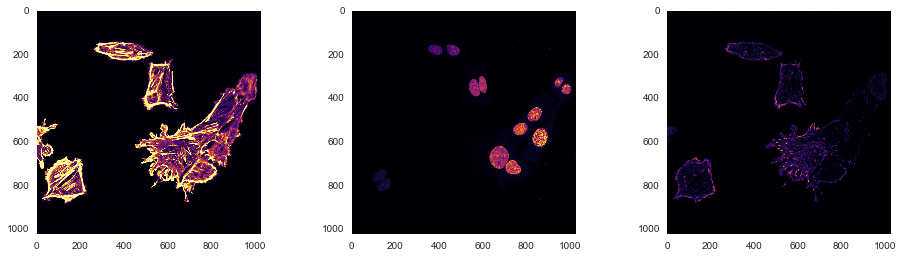

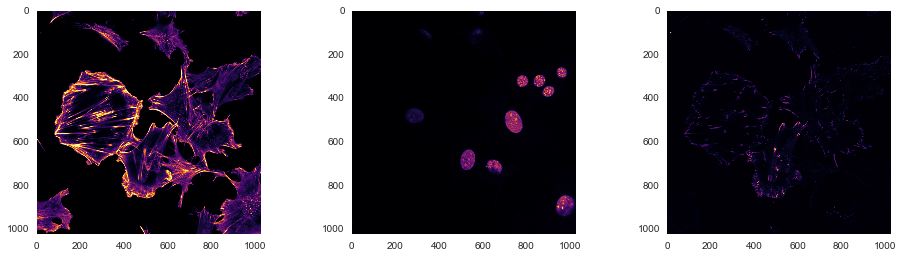

In [10]:
fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(wt["actin"])
ax[1].imshow(wt['nucleus'])
ax[2].imshow(wt["pax"])

fig, ax = plt.subplots(1, 3, figsize=(16, 4))
ax[0].imshow(vinc["actin"])
ax[1].imshow(vinc['nucleus'])
ax[2].imshow(vinc["pax"])

### Exercise: Use imshow to zoom in on a small section of the pax images to examine the small structures.

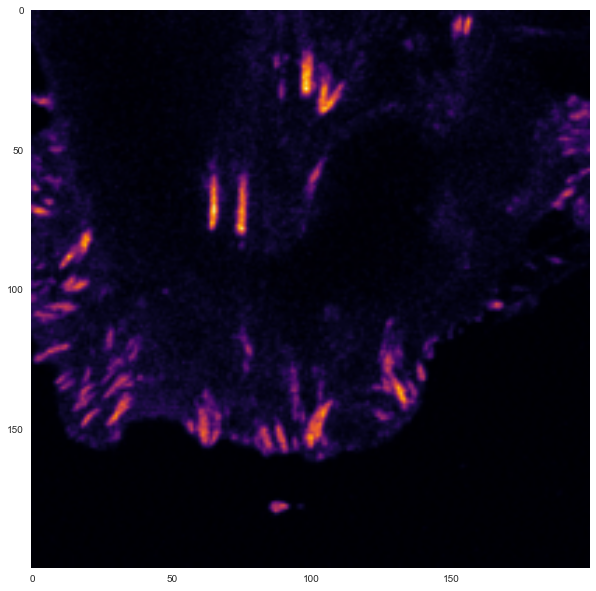

In [11]:
#answer to exercise
plt.figure(figsize=(20,10))
plt.imshow(vinc["pax"][700:900,400:600])

## Image pre-processing: a motivating example

Today, we will define the ROIs in the image. We'll find that the quality of masks can be improved by preprocessing the images by quantitatively determining thresholds and filtering to remove noise. We will then cover how to clean up the mask and turn it into an accurate ROI using morphological image processing. 

**Preprocessing misteps are a good way to get a paper retracted. We argue that it's easier to make these misteps when doing things manually, but it's not *impossible* to do it computationally. In fact if you don't check intermediate steps of your data in either case, it's no good. Always visualize your intermediates!**

### Exercise: write a function that has the following attributes:   
- Input: numerical threshold and input image
- Output: visualization of the the images binary mask

In [12]:
#answer
def mask_im(im, threshold):
    mask = np.zeros(im.shape)
    mask[im >=threshold] = 1
    plt.imshow(mask, vmin = 0, vmax = 1)
    return(mask)

In [13]:
vinc['actin'].dtype

dtype('uint16')

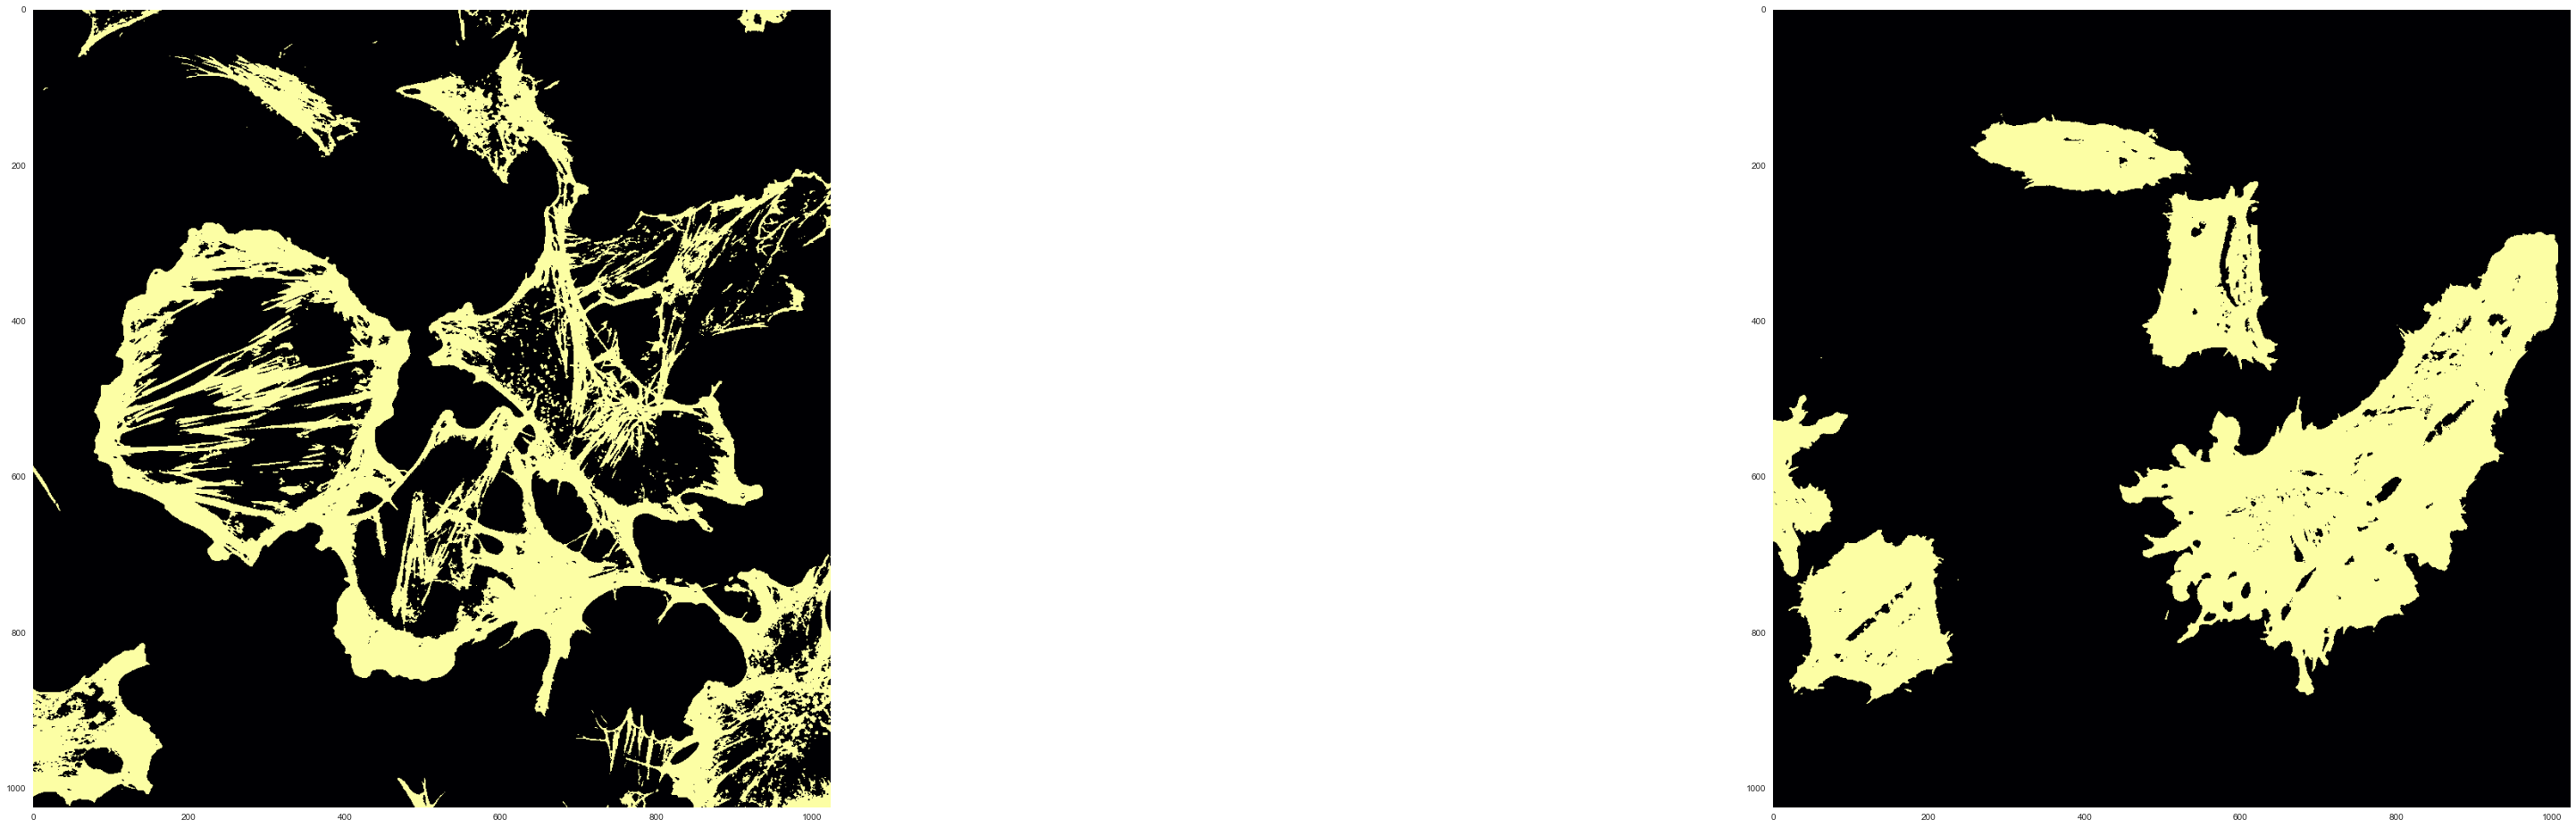

In [14]:
data1 = vinc["actin"]
data2 = wt["actin"]

from ipywidgets import interactive
@interactive
def show_masks(thresh=(0, data1.max() * 0.3, 40)):
    fig, ax = plt.subplots(1, 2, figsize=(64, 16))
    mask1 = np.zeros(data1.shape)
    mask2 = np.zeros(data2.shape)
    
    mask1[data1 >=thresh] = 1
    mask2[data2 >=thresh] = 1
    
    ax[0].imshow(mask1, vmin=0, vmax=1)
    ax[1].imshow(mask2, vmin=0, vmax=1)
show_masks

### Exercise: Determine a global threshold for the nucleus channel of both images. Discuss what is preventing this from working robustly.

Today, we will define the ROIs in this set of images. You may have noticed some qualities of the above images that make them hard to reliably threshold into masks relecting the relevant cell organelles.

Addressed in Preprocessing part 1:
1. There appears to be some variation in the background and intensity between actin datasets. Perhaps there was some variability in the focus when the image was taken, someone opened the microscope room door during imaging of one of the datasets, pipetting error when staining, or that some of the cells really do have more actin.   
    - automated thresholding methods
    
Addressed preprocessing part 2:
2. Noise corrupting the images
    - Introduction to Rank Filters: median filter
2. Uneven illumination in the nucleus channel makes finding a single threshold across a single image challenging. 
    - Rolling ball background subtraction
3. Uneven paxillin expression, low EGFP signal, and cytoplasmic signal complicate focal adhesion thresholding
    - thresholding within defined ROIs
    
Addressed in Morphological Operations:
4. Small blobs appear in nuclear mask, making it hard to count nuclei

Note that the size of the cell bodies depends on the threshold chosen. It may be challenging to choose a single threshold for making masks across datasets, especially if there are slight differences in focus or background. This emphasizes the need for more reproducible thresholding methods.

In [15]:
data = wt['actin'].copy()

### Automated detection of foreground using Otsu's method

Nobuyuki Otsu proposed a method (now very widely used) to detect thresholds. Simply put, the idea is to assume that background pixels (unwanted), and foreground pixels (your signal) will follow a bimodal distribution, i.e. that all the background pixels will be a well defined group on a histogram, which will be different from another well defined group that will be brighter, and is the signal that you want.

In [16]:
from skimage import filters

thresh = filters.threshold_otsu(data)
print("The objective masking threshold for this dataset is:", thresh)

The objective masking threshold for this dataset is: 23003


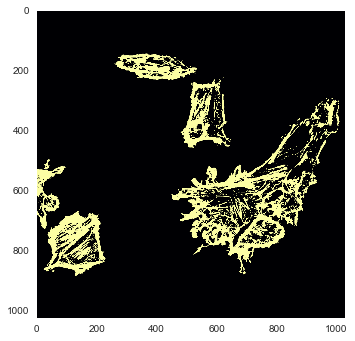

In [17]:
mask = mask_im(data,thresh)

Note that the global threshold produces masks with different qualities at the edges and the center of the image because of the uneven illumination throughout the sample. Observe the histogram of pixel intensities to see why this might be the case.

(0, 30000)

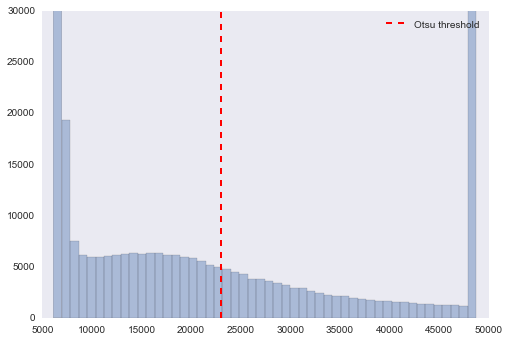

In [18]:
sns.distplot(data.flatten(), hist_kws={'log': False}, kde=False)
plt.axvline(thresh, ls='--', lw=2, c='r', label='Otsu threshold')
plt.legend()
plt.ylim(0,30000)

Both manual threshold determination and Otsu's threshold determination fail to produce high-quality masks in this dataset. Noise, uneven illumination, and background, which are all common in fluorescent microscopy datasets in biology, can be corrected using a set of *rank filters*

### Exercise: View the histogram of pixel values for the nucleus dataset. Does Otsu's method make sense? Perform Otsu's thresholding on the nucleus dataset.

In [19]:
nuc_thresh = filters.threshold_otsu(wt['nucleus'])
print("The calculated masking threshold for the nucleus is:", nuc_thresh)

The calculated masking threshold for the nucleus is: 9046


(0, 10000)

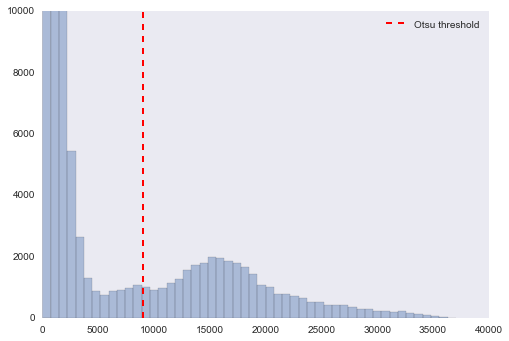

In [20]:
sns.distplot(wt['nucleus'].flatten(), hist_kws={'log': False}, kde=False)
plt.axvline(nuc_thresh, ls='--', lw=2, c='r', label='Otsu threshold')
plt.legend()
plt.ylim(0,10000)

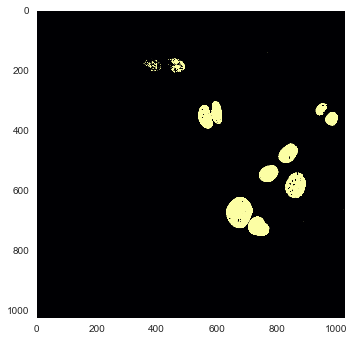

In [21]:
nuc_mask2 = mask_im(wt["nucleus"], nuc_thresh)

**NOTE:** we will save the application of Otsu's thresholding method to the image by imshow the mask in the next exercise.

Now back to our actin data. Spatial filtering (to be covered next) can help separate the intensity histogram into distinct peaks, which may improve the performance of Otsu's method. Below is a dataset which was heavily filtered to remove the saturated pixels, noise, and reduce the holes in the cytoplasm. Does Otsu's method work now? 

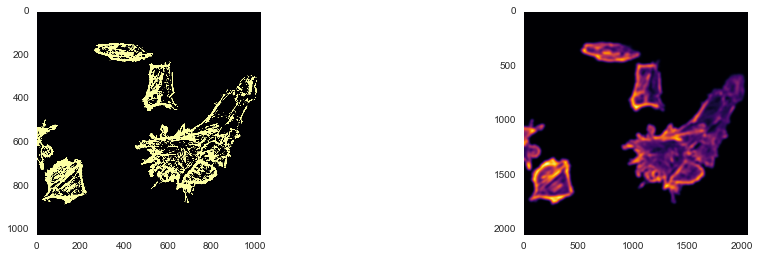

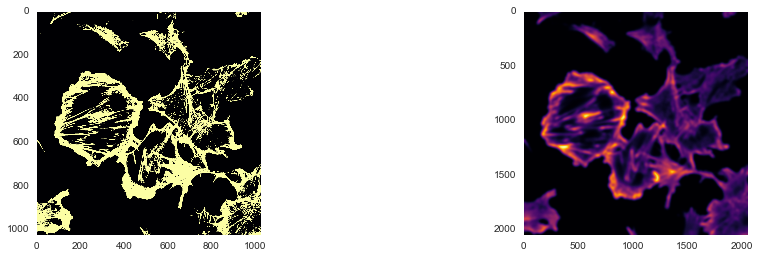

In [22]:
from skimage.io import imread
wt_im = imread("../fig/20170601-WT-DMSO-1-actin.tif")
vinc_im = imread("../fig/20170601-vincKO-DMSO-1-actin.tif")

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
wt_act_mask = mask_im(wt['actin'], filters.threshold_otsu(wt_im))
ax[0].imshow(mask, vmin = 0, vmax = 1)
ax[1].imshow(wt_im)

fig, ax = plt.subplots(1, 2, figsize=(16, 4))
mask = mask_im(vinc['actin'], filters.threshold_otsu(vinc_im) )
ax[0].imshow(mask, vmin=0, vmax=1)
ax[1].imshow(vinc_im)


(0, 300000)

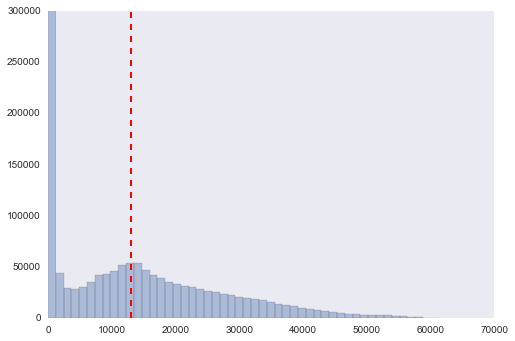

In [23]:
from skimage import filters
wt_thresh= filters.threshold_otsu(wt_im)

sns.distplot(wt_im.flatten(), hist_kws={'log': False}, kde=False)
plt.axvline(wt_thresh, ls='--', lw=2, c='r')
plt.gca().set_ylim([0, 300000])

This threshold seems like it's dividing a cluster instead of separating two clusters, even though empirically the histogram looks like two populations. While Otsu's is the most recognized of the thresholding algorithms, it's ok if after all reasonable processing steps it still fails. 

### Exercise: Determine what is incorrect about the application of Otsu's method below (there are two independent errors)

the Otsu masking threshold for this dataset is: 4028.43759855


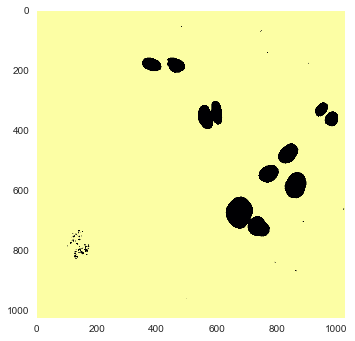

In [24]:
data = wt['nucleus']

from skimage import filters
nuc_thresh = filters.threshold_li(data) # Error 1: threshold method name is wrong!
print("the Otsu masking threshold for this dataset is:", nuc_thresh)

nuc_mask = np.zeros(data.shape)
nuc_mask[data <= nuc_thresh] = 1 # Error 2: binary assignment should be 0

plt.imshow(nuc_mask, vmin=0, vmax=1)

### **Exercise** Otsu's method performs sub-optimally in this case because of the distribution of background and foreground values. 
Find the documentation for the scipy filter options and determine if another thresholding algorithm would be more appropriate. 

83


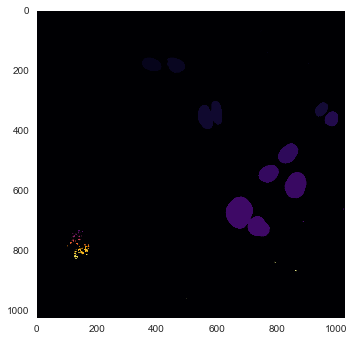

In [25]:
from skimage.morphology import label
nuc_mask = mask_im(wt["nucleus"], filters.threshold_li(data))
plt.imshow(label(nuc_mask))
print(label(nuc_mask).max())

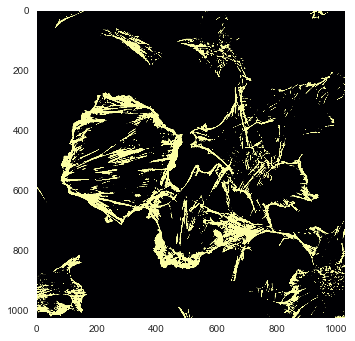

In [26]:
wt_masks = {}
vinc_masks = {}

for ch in wt:
    wt_masks[ch] = mask_im(wt[ch], filters.threshold_otsu(wt[ch]))
    vinc_masks[ch] = mask_im(vinc[ch], filters.threshold_otsu(vinc[ch]))

In [27]:
total_spread_area_wt = np.sum(wt_masks["actin"])
total_spread_area_vinc = np.sum(vinc_masks["actin"])

num_cells_wt = np.max(label(wt_masks["nucleus"]))
num_cells_vinc = np.max(label(vinc_masks["nucleus"]))

print("spread area per WT cell is" , total_spread_area_wt/num_cells_wt, "pixels")
print("for" , num_cells_wt, "cells")
print( )
print("spread area per vincKO cell is" , total_spread_area_vinc/num_cells_vinc, "pixels")
print("for" , num_cells_vinc, "cells")

spread area per WT cell is 1687.59701493 pixels
for 67 cells

spread area per vincKO cell is 3247.26315789 pixels
for 38 cells
